In [28]:
# libraries
import pandas as pd
from matplotlib import pyplot
from sklearn import metrics 
from sklearn.model_selection import KFold
import numpy as np 
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
from sklearn import metrics 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [29]:
#paths to the file containing the samples with the processed features
feature_of_counts = "../processed_data/feature_vectors_counts.csv"

In [30]:
# Importing the dataset, and performing an undersampling of the benignware
dataset = pd.read_csv(feature_of_counts, index_col=0)

X = dataset.iloc[:,1:9].values
y = dataset.iloc[:, 9].values

# Splitting (randomly) the dataset into the Training set and the (unseen) Test set
# Note this is only for the first task of the coursework. You'll need a different approach for the other tasks, as they also need a validation stage in addition to the test with unseen data.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y.astype(int), random_state=42, test_size = 0.2)

from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler(sampling_strategy='majority')

X_train, y_train = undersample.fit_resample(X_train, y_train)


In [31]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


## Random Forest Classifier

Based on [this](https://blog.dataiku.com/narrowing-the-search-which-hyperparameters-really-matter) article, min_samples_leaf and max_features are the most important hyperparameters for the Random Forest Classifier. At least for his project.

In [32]:
# Fitting the model to the Training set
from sklearn.ensemble import RandomForestClassifier

In [33]:
# creating a RF classifier and performing a crossvalidation for it
# Converting X_train and y_train to numpy arrays
X_train_RF , y_train_RF = np.array(X_train), np.array(y_train)

# Defining number of splits for cross-validation and shuffling the data
kf = KFold(n_splits=3, shuffle=True)

# Initialize variables to track the best parameters and corresponding AUC
average_auc_RF_max = 0 
min_samples_leaf_best = 0 
max_features_best = 0

# Loop through different values of min_samples_leaf and max_features
for min_samples_leaf in [1, 20, 40]:
    for max_features in [None, "sqrt", 0.2]:
        # Initialize average AUC score for this parameter combination
        average_auc = 0
        # Perform k-fold cross-validation
        for train, test in kf.split(X_train_RF):
            # Split the data into training and testing sets for this fold
            training_X , training_y = X_train_RF[train], y_train_RF[train]
            test_X, test_y = X_train_RF[test], y_train_RF[test]

            # Initialize and train the Random Forest classifier
            clf = RandomForestClassifier(min_samples_leaf=min_samples_leaf, max_features=max_features, random_state=42)
            clf.fit(training_X, training_y)
            
            # Predict probabilities for the test set
            scores_clf = clf.predict_proba(test_X)[:,1]

            # Calculate AUC score for this fold
            AUC_rfc = metrics.roc_auc_score(test_y, scores_clf)
            average_auc += AUC_rfc
        
        # Calculate the average AUC score across all folds
        average_auc /= kf.get_n_splits()
        
        # Update the best parameters and corresponding AUC if current parameters yield better result
        if average_auc > average_auc_RF_max:
            average_auc_RF_max = average_auc
            min_samples_leaf_best = min_samples_leaf
            max_features_best = max_features
            print(f"min_samples_leaf: {min_samples_leaf_best}, max_features: {max_features_best} gives the average AUC: {average_auc_RF_max}")


min_samples_leaf: 1, max_features: None gives the avarage AUC: 0.9762829596270756
min_samples_leaf: 1, max_features: sqrt gives the avarage AUC: 0.9813839915949086


ACCURACY OF THE MODEL for Random forest: 0.9370615819865907
PRECISION OF MODEL for Random forest: 0.40130819545979224
RECALL OF MODEL for Random forest: 0.9387938793879388
F1-SCORE OF MODEL for Random forest: 0.5622641509433962


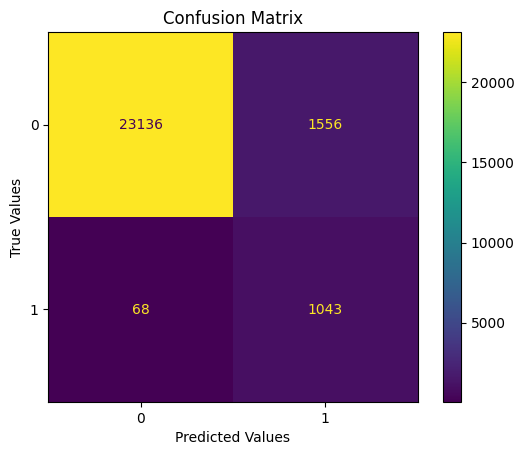

In [34]:
clf_best = RandomForestClassifier(min_samples_leaf=min_samples_leaf_best, max_features=max_features_best, random_state=42)
clf_best.fit(X_train, y_train)

scores_clf_best = clf_best.predict(X_test)

print("ACCURACY OF THE MODEL for Random forest:", metrics.accuracy_score(y_test, scores_clf_best))
print("PRECISION OF MODEL for Random forest:", metrics.precision_score(y_test, scores_clf_best))
print("RECALL OF MODEL for Random forest:", metrics.recall_score(y_test, scores_clf_best))
print("F1-SCORE OF MODEL for Random forest:", metrics.f1_score(y_test, scores_clf_best))

ConfusionMatrixDisplay.from_estimator(clf_best, X_test, y_test)
plt.title('Confusion Matrix')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')
plt.show()



## Logistic Regression

In [35]:
from sklearn.linear_model import LogisticRegression

In [36]:
# Converting X_train and y_train to numpy arrays
X_train_log, y_train_log = np.array(X_train), np.array(y_train)

# Defining number of splits for cross-validation and shuffling the data
kf = KFold(n_splits=3, shuffle=True)

# Initialize variables to track the best parameters and corresponding AUC
average_auc_log_min = 0 
algorithm_best = ""
toleration_best = 0
regulation_best = 0 
iter_best = 0 

# Loop through different values of algorithm, toleration, regulation, and iteration
for algorithm in ['lbfgs', 'newton-cg']:
    for toleration in (1e-4, 1e-3, 1e-2):
        for regulation in (1e-1, 1e1):
            for iteration in (100, 1000):
                # Initialize average AUC score for this parameter combination
                average_auc = 0 
                
                # Perform k-fold cross-validation
                for train, test in kf.split(X_train_log):
                    # Split the data into training and testing sets for this fold
                    training_X, training_y = X_train_log[train], y_train_log[train]
                    test_X, test_y = X_train_log[test], y_train_log[test]
                    
                    # Initialize and train the Logistic Regression model
                    log = LogisticRegression(solver=algorithm, tol=toleration, C=regulation, random_state=42, max_iter=iteration)
                    log.fit(training_X, training_y)
                    
                    # Predict probabilities for the test set
                    scores_log = log.predict_proba(test_X)[:,1]

                    # Calculate AUC score for this fold
                    AUC_log = metrics.roc_auc_score(test_y, scores_log)
                    average_auc += AUC_log
                
                # Calculate the average AUC score across all folds
                average_auc /= kf.get_n_splits()
                
                # Update the best parameters and corresponding AUC if current parameters yield better result
                if average_auc > average_auc_log_min:
                    average_auc_log_min = average_auc 
                    algorithm_best = algorithm
                    toleration_best = toleration
                    regulation_best = regulation
                    iter_best = iteration
                    print(f"Solver {algorithm_best}, toleration {toleration_best}, regulation {regulation_best}, iteration {iter_best} gives the average AUC of {average_auc_log_min}")
 

Solver lbfgs, toleration 0.0001, regulation 0.1, itteration 100 gives the avarage AUC of 0.894947
Solver lbfgs, toleration 0.0001, regulation 10, itteration 100 gives the avarage AUC of 0.896662


ACCURACY OF THE MODEL for Random forest: 0.8593961942409797
PRECISION OF MODEL for Random forest: 0.20395201129146084
RECALL OF MODEL for Random forest: 0.7803780378037803
F1-SCORE OF MODEL for Random forest: 0.3233867959716524


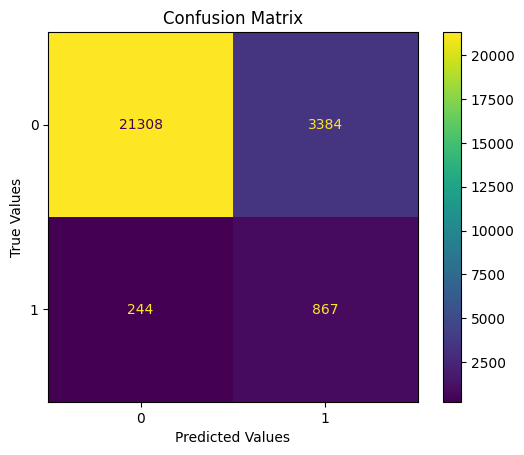

In [37]:
log_best = LogisticRegression(solver = algorithm_best, tol = toleration_best, C= regulation_best, random_state = 42,  max_iter=iter_best)
log_best.fit(X_train, y_train)
scores_log_best = log_best.predict(X_test)

print("ACCURACY OF THE MODEL for Random forest:", metrics.accuracy_score(y_test, scores_log_best))
print("PRECISION OF MODEL for Random forest:", metrics.precision_score(y_test, scores_log_best))
print("RECALL OF MODEL for Random forest:", metrics.recall_score(y_test, scores_log_best))
print("F1-SCORE OF MODEL for Random forest:", metrics.f1_score(y_test, scores_log_best))

ConfusionMatrixDisplay.from_estimator(log_best, X_test, y_test)
plt.title('Confusion Matrix')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')
plt.show()

## Gradient Boosting Classifier

[This](https://aiml.com/what-are-the-key-hyper-parameters-for-a-gbm-model/) article defines *learning_rate* and *n_estimators* as the two most important hyperparameters

In [38]:
from sklearn.ensemble import GradientBoostingClassifier

In [39]:
# Converting X_train and y_train to numpy arrays
X_train_GBC, y_train_GBC = np.array(X_train), np.array(y_train)

# Defining number of splits for cross-validation and shuffling the data
kf = KFold(n_splits=3, shuffle=True)

# Initialize variables to track the best parameters and corresponding AUC
average_auc_gbc_min = 0 
learning_rate_best = 0
n_estimators_best = 0

# Loop through different values of learning_rate and n_estimators
for learning_rate in [0.05, 0.1, 0.2]:
    for n_estimators in [2, 8, 16]:
        # Initialize average AUC score for this parameter combination
        average_auc = 0 
        # Perform k-fold cross-validation
        for train, test in kf.split(X_train_GBC):
            # Split the data into training and testing sets for this fold
            training_X , training_y = X_train_GBC[train], y_train_GBC[train]
            test_X, test_y = X_train_GBC[test], y_train_GBC[test]

            # Initialize and train the Gradient Boosting classifier
            gb = GradientBoostingClassifier(learning_rate=learning_rate, n_estimators=n_estimators, random_state=42)
            gb.fit(training_X, training_y)
            
            # Predict probabilities for the test set
            scores_gb = gb.predict_proba(test_X)[:,1]

            # Calculate AUC score for this fold
            AUC_gb = metrics.roc_auc_score(test_y, scores_gb)
            average_auc += AUC_gb
            
        # Calculate the average AUC score across all folds
        average_auc /= kf.get_n_splits()
        
        # Update the best parameters and corresponding AUC if current parameters yield better result
        if average_auc > average_auc_gbc_min:
            average_auc_gbc_min = average_auc
            learning_rate_best = learning_rate
            n_estimators_best = n_estimators
            print(f"learning_rate: {learning_rate_best}, n_estimators: {n_estimators_best} gives the average AUC: {average_auc_gbc_min}")

learning_rate: 0.05, n_estimators: 2 gives the avarage AUC: 0.8693674249272355
learning_rate: 0.05, n_estimators: 8 gives the avarage AUC: 0.8918555417121704
learning_rate: 0.05, n_estimators: 16 gives the avarage AUC: 0.90327716579043
learning_rate: 0.1, n_estimators: 16 gives the avarage AUC: 0.9167721956820815
learning_rate: 0.2, n_estimators: 16 gives the avarage AUC: 0.9323478548058927


ACCURACY OF THE MODEL for Random forest: 0.8793938689299694
PRECISION OF MODEL for Random forest: 0.24100440072482526
RECALL OF MODEL for Random forest: 0.8379837983798379
F1-SCORE OF MODEL for Random forest: 0.3743466023321271


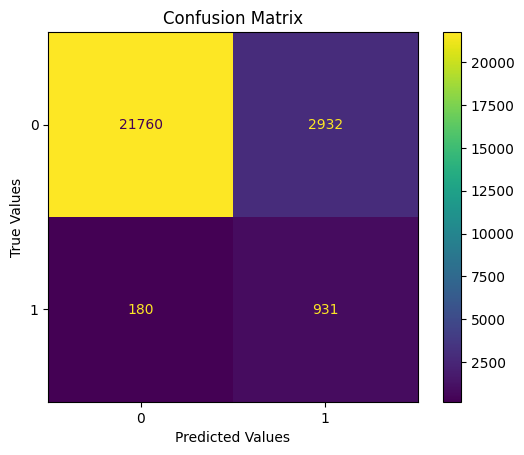

In [40]:
gb_best = GradientBoostingClassifier(learning_rate=learning_rate_best,n_estimators=n_estimators_best ,random_state=42)
gb_best.fit(X_train, y_train)
scores_gb_best = gb_best.predict(X_test)

print("ACCURACY OF THE MODEL for Random forest:", metrics.accuracy_score(y_test, scores_gb_best))
print("PRECISION OF MODEL for Random forest:", metrics.precision_score(y_test, scores_gb_best))
print("RECALL OF MODEL for Random forest:", metrics.recall_score(y_test, scores_gb_best))
print("F1-SCORE OF MODEL for Random forest:", metrics.f1_score(y_test, scores_gb_best))

ConfusionMatrixDisplay.from_estimator(gb_best, X_test, y_test)
plt.title('Confusion Matrix')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')
plt.show()

## Ada Boost Classifier

[This](https://medium.com/swlh/the-hyperparameter-cheat-sheet-770f1fed32ff) article defines *n_estimators* as the most important hyperparameter, with *learning_rate* and *base_estimator* as two other important ones. We will tweak n_estimators and learning_rate.

In [41]:
from sklearn.ensemble import AdaBoostClassifier

In [42]:
# Converting X_train and y_train to numpy arrays
X_train_abc, y_train_abc = np.array(X_train), np.array(y_train)

# Defining number of splits for cross-validation and shuffling the data
kf = KFold(n_splits=3, shuffle=True)

# Initialize variables to track the best parameters and corresponding AUC
average_auc_abc_min = 0 
learning_rate_best = 0
n_estimators_best = 0 

# Loop through different values of learning_rate and n_estimators
for learning_rate in [0.05, 0.1, 0.2]:
    for n_estimators in [2, 8, 16]:
        # Initialize average AUC score for this parameter combination
        average_auc = 0 
        # Perform k-fold cross-validation
        for train, test in kf.split(X_train_abc):
            # Split the data into training and testing sets for this fold
            training_X , training_y = X_train_abc[train], y_train_abc[train]
            test_X, test_y = X_train_abc[test], y_train_abc[test]

            # Initialize and train the AdaBoost classifier
            abc = AdaBoostClassifier(learning_rate=learning_rate, n_estimators=n_estimators, random_state=42)
            abc.fit(training_X, training_y)
            
            # Predict probabilities for the test set
            scores_abc = abc.predict_proba(test_X)[:,1]

            # Calculate AUC score for this fold
            AUC_abc = metrics.roc_auc_score(test_y, scores_abc)
            average_auc += AUC_abc

        # Calculate the average AUC score across all folds
        average_auc /= kf.get_n_splits()
        
        # Update the best parameters and corresponding AUC if current parameters yield better result
        if average_auc > average_auc_abc_min:
            average_auc_abc_min = average_auc
            learning_rate_best = learning_rate
            n_estimators_best = n_estimators
            print(f"learning_rate: {learning_rate_best}, n_estimators: {n_estimators_best} gives the average AUC: {average_auc_abc_min}")
            

learning_rate: 0.05, n_estimators: 2 gives the avarage AUC: 0.2555826782061217
learning_rate: 0.05, n_estimators: 8 gives the avarage AUC: 0.27461828297559276
learning_rate: 0.05, n_estimators: 16 gives the avarage AUC: 0.27906812138187337
learning_rate: 0.1, n_estimators: 16 gives the avarage AUC: 0.2845239287296472
learning_rate: 0.2, n_estimators: 16 gives the avarage AUC: 0.2897676678773378


ACCURACY OF THE MODEL for Random forest: 0.8248653257373174
PRECISION OF MODEL for Random forest: 0.1712962962962963
RECALL OF MODEL for Random forest: 0.7992799279927992
F1-SCORE OF MODEL for Random forest: 0.28212867355043686


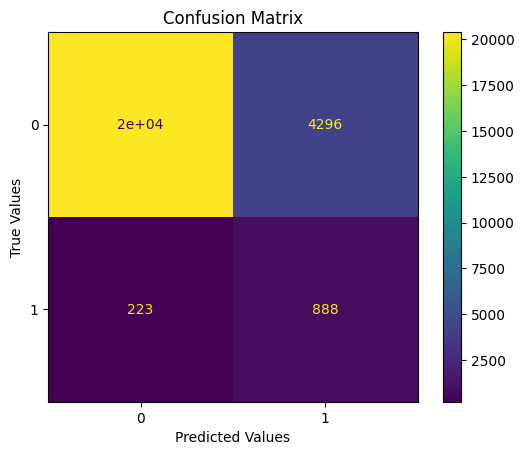

In [43]:
abc_best = AdaBoostClassifier(learning_rate=learning_rate_best, n_estimators=n_estimators_best,random_state=42)
abc_best.fit(X_train, y_train)
scores_abc_best = abc_best.predict(X_test)

print("ACCURACY OF THE MODEL for Random forest:", metrics.accuracy_score(y_test, scores_abc_best))
print("PRECISION OF MODEL for Random forest:", metrics.precision_score(y_test, scores_abc_best))
print("RECALL OF MODEL for Random forest:", metrics.recall_score(y_test, scores_abc_best))
print("F1-SCORE OF MODEL for Random forest:", metrics.f1_score(y_test, scores_abc_best))

ConfusionMatrixDisplay.from_estimator(abc_best, X_test, y_test)
plt.title('Confusion Matrix')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')
plt.show()